In [2]:
!pip install sentence-transformers stopwordsiso


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import stopwordsiso as stopwords_iso
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sentence_transformers import SentenceTransformer

In [4]:
# ----------------------------------
# STEP 1: Install + Mount Google Drive
# ----------------------------------
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# -----------------------------
# Preprocessing
# -----------------------------
nltk.download('punkt')

df = pd.read_csv('/content/drive/My Drive/E_Commerce/final_balanced_all.csv')
df.dropna(subset=['text', 'intent', 'lang'], inplace=True)
df = df[df['text'].str.strip().astype(bool)]

lang_stopwords = {
    'en': set(stopwords_iso.stopwords("en")),
    'hi': set(stopwords_iso.stopwords("hi")),
    'es': set(stopwords_iso.stopwords("es")),
}


def clean_text(text, lang='en'):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()  # 🔄 Replace nltk tokenizer
    tokens = [t for t in tokens if t not in lang_stopwords.get(lang, set())]
    return ' '.join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import nltk
nltk.download('punkt', force=True)  # Force fresh download
df['clean_text'] = df.apply(lambda row: clean_text(row['text'], row['lang']), axis=1)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
# -----------------------------
# Sentence Embeddings
# -----------------------------
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_embeddings = embedder.encode(df['clean_text'].tolist(), show_progress_bar=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/294 [00:00<?, ?it/s]

In [8]:
# -----------------------------
# Labels
# -----------------------------
le = LabelEncoder()
y = le.fit_transform(df['intent'])


In [9]:
# -----------------------------
# Models to Compare
# -----------------------------
from sklearn.svm import LinearSVC
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=300)
}

In [10]:
# -----------------------------
# Stratified Cross-Validation
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_accuracies = {}

for model_name, model in models.items():
    print(f"\n======== {model_name} ========")
    accuracies = []
    fold = 1

    for train_index, test_index in skf.split(X_embeddings, y):
        X_train = np.array(X_embeddings)[train_index]
        X_test = np.array(X_embeddings)[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        print(f"\nFold {fold} Accuracy: {acc:.2f}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        fold += 1

    avg_acc = np.mean(accuracies)
    print(f"\n✅ Avg Accuracy for {model_name}: {avg_acc:.2f}")
    model_accuracies[model_name] = avg_acc



======== Logistic Regression ========

Fold 1 Accuracy: 0.81
                      precision    recall  f1-score   support

        cancel_order       0.77      0.85      0.81       235
      change_address       0.90      0.91      0.91       234
       confirm_order       0.78      0.80      0.79       234
     contact_advisor       0.81      0.85      0.83       235
       general_query       0.73      0.60      0.65       235
get_list_of_products       0.78      0.77      0.77       234
       not_ecommerce       0.84      0.78      0.81       235
        order_status       0.84      0.89      0.86       235

            accuracy                           0.81      1877
           macro avg       0.80      0.81      0.80      1877
        weighted avg       0.80      0.81      0.80      1877


Fold 2 Accuracy: 0.79
                      precision    recall  f1-score   support

        cancel_order       0.75      0.76      0.75       234
      change_address       0.93      0.90  

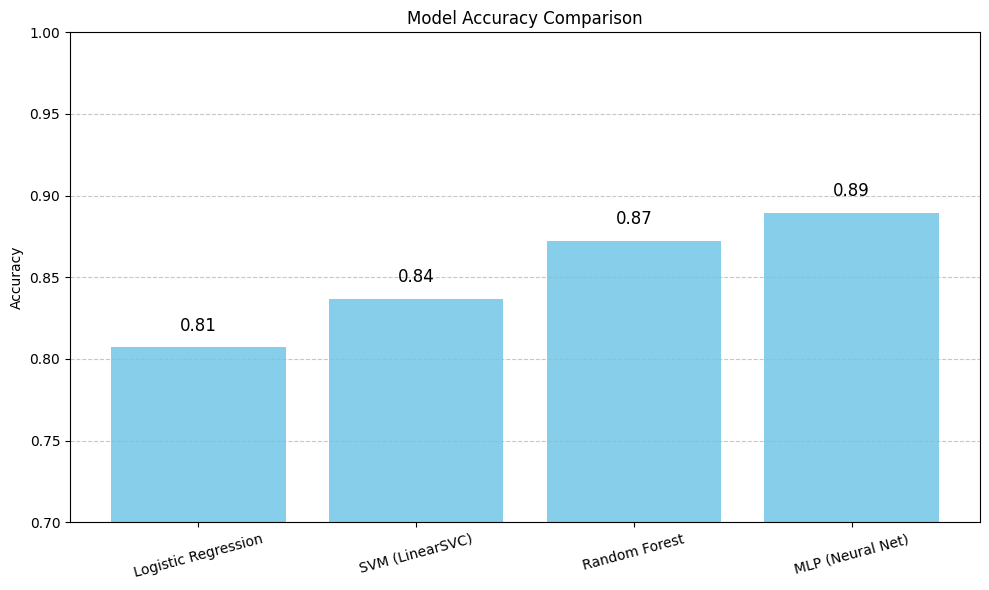

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
for i, v in enumerate(model_accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
best_model = models["MLP (Neural Net)"]


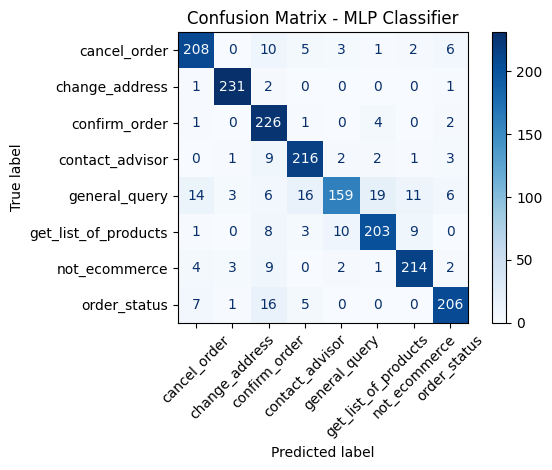

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Get predictions (assuming X_test is from your embeddings)
y_pred = model.predict(X_test)  # Replace with actual X_test

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - MLP Classifier")
plt.tight_layout()
plt.show()


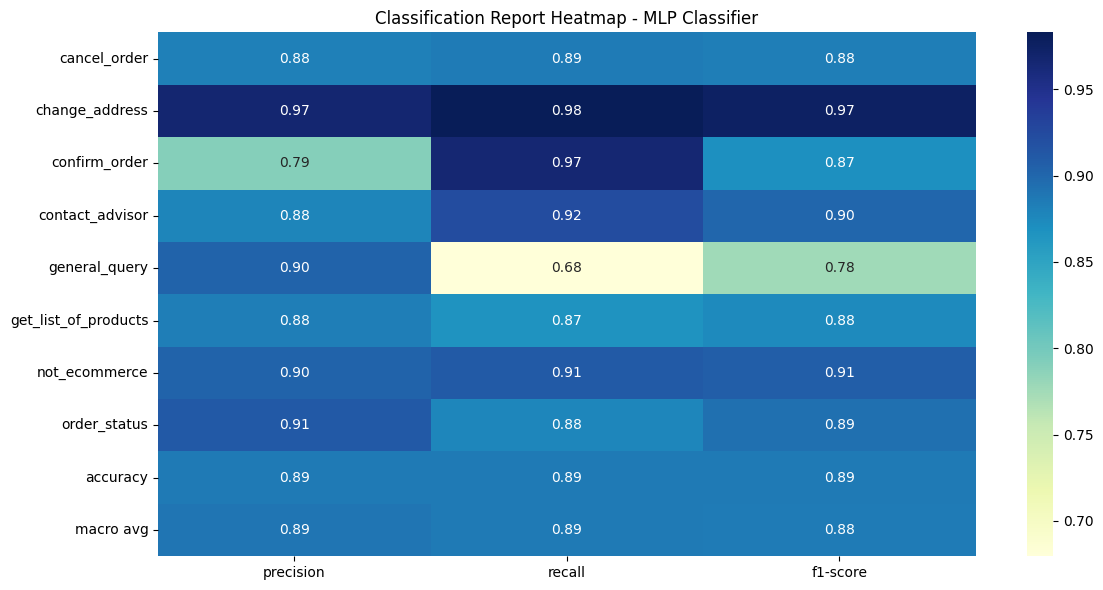

In [14]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap - MLP Classifier")
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Save MLP model
joblib.dump(best_model, '/content/drive/My Drive/E_Commerce/mlp_intent_classifier.pkl')

# Save label encoder
joblib.dump(le, '/content/drive/My Drive/E_Commerce/label_encoder.pkl')

# Save the sentence embedding model
embedder.save('/content/drive/My Drive/E_Commerce/embedding_model')


## ***Test Model:***

In [ ]:
# Load everything
import joblib
from sentence_transformers import SentenceTransformer

model = joblib.load('/content/drive/My Drive/E_Commerce/mlp_intent_classifier.pkl')
le = joblib.load('/content/drive/My Drive/E_Commerce/label_encoder.pkl')
embedder = SentenceTransformer('/content/drive/My Drive/E_Commerce/embedding_model')


In [ ]:
import re
import stopwordsiso as stopwords_iso

# Setup multilingual stopwords again
lang_stopwords = {
    'en': set(stopwords_iso.stopwords("en")),
    'hi': set(stopwords_iso.stopwords("hi")),
    'es': set(stopwords_iso.stopwords("es")),
}

def preprocess_text(text, lang='en'):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in lang_stopwords.get(lang, set())]
    return ' '.join(tokens)


In [ ]:
def predict_intent(user_text, lang='en'):
    clean = preprocess_text(user_text, lang)
    embedding = embedder.encode([clean])
    prediction = model.predict(embedding)
    intent = le.inverse_transform(prediction)[0]
    return intent


In [ ]:
# English
print(predict_intent("Where can I contact customer service?", lang='en'))

# Hindi
print(predict_intent("मेरा ऑर्डर कहाँ है?", lang='hi'))

# Spanish
print(predict_intent("¿Dónde está mi pedido?", lang='es'))


contact_advisor
order_status
order_status
